---
# Logistic Regression with Feature Extraction
---
Notebook Summary:

Performing feature extraction on the MNIST sign language dataset using three different methods. The result of feature extraction are feature vectors which will be used to train a Logisitic Regression Model. 

### Feature Extraction Methods:
- **HOG (Histogram Oriented Gradients)**
    - Identifies edges and textures from raw input image data by creating feature vectors.
- **LBP (Local Binary Patterns)**
    - Identifies textures from raw input image data by comparing each pixel with its neighbouring pixels.
- **Colour Histogram**
    - Shows the distribution of colours from raw images.

### Notebook Overview:

- **Data Loading**:
    - Load the MNIST sign language dataset.

- **Feature Extraction**:
    - Assess output of each feature extraction method

- **Build the Logistic Regression Model**:
    - Transform X into feature vectors
    - Split the data into training and testing sets.
    - Train a Logistic Regression model on the feature vectors.

- **Model Evaluation**:
    - Assess the accuracy and performance of the Logistic Regression model.
    - Assess the feature vectors to see what the model interprets the most defining features for letter 


## Set Up

In [3]:

# List of imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler

import joblib
import math

## Data Loading

In [2]:
# connect to google drive -> required for input image later
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# X  = joblib.load( '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/X.pkl' )
# y = joblib.load( '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/y.pkl' )
X  = joblib.load( '../../model/my_files/X.pkl' )
y = joblib.load( '../../model/my_files/y.pkl' )

In [5]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

## Utility Functions

In [6]:
def extract_features(image):
  '''
    Overview:
    Extracts HOG, LBP, and color histogram features from a 28x28 image.

    Arguments:
        - single image

    Output:
        - feature vector for a given image
  '''
  # Reshape the image if it's flattened
  image = image.reshape(28, 28)

  # Histogram of Orientated Gradients (HOG) Features
  hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

  # LBP Features (Uniform LBP with 8 neighbors)
  lbp_features = local_binary_pattern(image, P=8, R=1, method='uniform')
  lbp_hist, bin_edges = np.histogram(lbp_features, bins=np.arange(0, lbp_features.max() + 2), density=True)

  # Color Histogram Features (8 bins per channel) -> distribution of colour (greyscale in this case)
  color_hist, bin_edges = np.histogram(image, bins=8, range=(0, 255), density=True)

  # Combining features into a single vector
  feature_vectors = np.concatenate((hog_features, lbp_hist, color_hist))

  return feature_vectors


# Function to plot output of the feature extraction methods
def feature_plots(input_letter):
    '''
      Overview:
        Plot to compare the original input image with the output of a given feature extraction method.

      Arguments:
        - input_letter: letter (NOT J/Z as both of these letters do not exist in dataset).
        - feature_image: The output image after feature extraction.

      Output:
        - 2 figures:
            - input image of given letter
            - image of 'new' feature
    '''

    my_image = X.reshape(-1,28,28)
    my_class = y

    if input_letter.lower() in ('j', 'z'):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        fig, axes = plt.subplots(1,3, figsize=(10, 5))

        idx1 = alphabet.index(input_letter.lower())

        feature_vector, hog_image  = hog(my_image[my_class==idx1][0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        lbp_features = local_binary_pattern(my_image[my_class==idx1][0], P=8, R=1, method='uniform')

        axes[0].imshow(lbp_features, cmap="gray")
        axes[0].set_title(f'Image of {input_letter.upper()} after LBP')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].imshow(my_image[my_class==idx1][0], cmap="gray")
        axes[1].set_title(f'Input Image of {input_letter.upper()}')
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        hog_image_norm = hog_image/255.0
        axes[2].imshow(hog_image_norm, cmap="gray")
        axes[2].set_title(f'Image of {input_letter.upper()} after HOG')
        axes[2].set_xticks([])
        axes[2].set_yticks([])

        plt.tight_layout()
        plt.show()

def colour_hist(input_letter):
    '''
      Overview:
        Plot the colour histogram for a given letter

      Arguments:
        - input_letter: letter (NOT J/Z as both of these letters do not exist in dataset).

      Output:
        - Histogram of pixel instensities for a given letter
    '''
    my_image = X.reshape(-1,28,28)
    my_class = y

    if input_letter.lower() in ('j', 'z'):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        idx1 = alphabet.index(input_letter.lower())

        fig, ax = plt.subplots()

        ax.hist(my_image[my_class==idx1][0].reshape(784,-1), bins=8 ,range=(0, 255), edgecolor = 'black', color = 'teal')

        # Add labels and title
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Pixel Intensity Distribution of {input_letter.upper()}')
        ax.spines[['top', 'right']].set_visible(False)

        # Show plot
        plt.show()


def assess_coef(coef, letter_1, letter_2):
    '''
    Overview:
    Plots vector coefficients for letter_1 and letter_2 .

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter_1 -> Letter (NOT J/Z as both of these letters do not exist in dataset)
        - letter_2 -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            - vector coefficient for letter_1
            - vector coefficient for letter_2

    '''
    if (letter_1.lower() in ('j', 'z')) or (letter_2.lower() in ('j', 'z')):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        fig, axes = plt.subplots(2,1, figsize=(15, 5))

        # get index of letter as class is int data type
        idx_1= alphabet.index(letter_1.lower()) # having to use second alphabet list here without j and z as indicies for coef do not align with target
        idx_2= alphabet.index(letter_2.lower())

        axes[0].imshow(np.tile(coef[idx_1], (10, 1)),cmap = 'gray')
        axes[0].set_title(letter_1.upper(),fontsize='20')
        axes[0].set_yticks([])

        axes[1].imshow(np.tile(coef[idx_2], (10, 1)),cmap = 'gray')
        axes[1].set_title(letter_2.upper(),fontsize='20')
        axes[1].set_yticks([])

        plt.tight_layout()
        plt.show()



## Assessing the 3 Different Feature Extraction Methods

/Users/simybasra/anaconda3/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


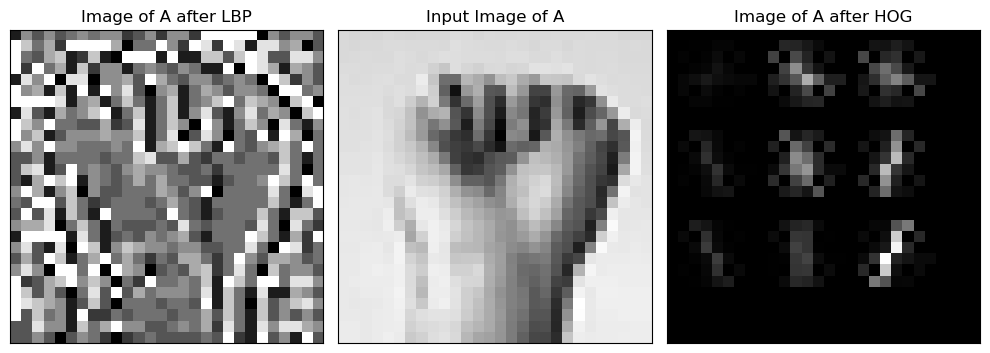

In [7]:
feature_plots('a')

**Plot Description**

LBP:
LBP compares pixel intensity around each pixel to its own intensity. Neighbouring pixels > given pixel instensity are assigned a value of 1 if not, 0. This process captures the edges and textures of the hand in the example above.

Darker areas indicate areas of uniformity - by this I mean textures are smoother and more uniform. This makes sense as the darker areas in the plot looks like an outline of the input image. The lighter areas in the LBP plot highlight areas where there is great difference in texture, these areas are usually more indicative and unique to each sign.

HOG:
Calculates the gradient of neighbouring pixel intensities for a given pixel, the gradeint is used to get the magnitude and direction of changes in the neighbouring pixel instensities. We then use the magnitude and direction to plot a histogram where the number of bins represent the direction and the frequency is calculated using the magnitude. The histograms are normalised and concatentated to create a final feature vector of the image.

The feature vector for hog also provides information on texture (middle cluster we see in the above iamge) and edges. The white areas show us parts of the image where the changes in the gradient are at the highest tehrefore shows us texture/edges.


### Colour Extraction

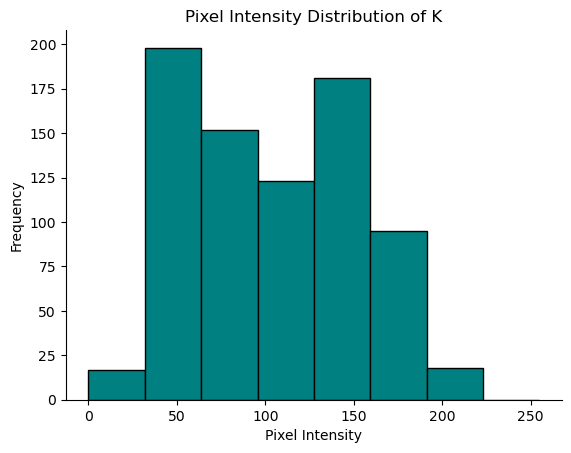

In [8]:
colour_hist('k')

**Plot Description:**

Colour Histogram to show us the distribution of colour in image, this technique provides more value when there are RGB colour channels in our data. 

Main insight here is that a lot of the colour we see in our data is towards the white end of the scale. This makes sense as the background of these images are towards the white end of the scale.

## Building the Logistic Model


### Transform images to feature vectors


In [9]:
# creating feature vectors for all images in dataset
image_feature_vectors = []
for image in X:
    image_feature_vectors.append(extract_features(image))
image_feature_vectors = np.array(image_feature_vectors)


In [10]:
# Sanity check on shape
image_feature_vectors.shape

(34627, 162)

### Test/Train Data Split

In [11]:
X_vec = image_feature_vectors

In [26]:
X_vec.shape

(34627, 162)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_vec, y, test_size = 0.2, random_state=1)

In [13]:
# Using saga algorithm with lasso penalty, saga algorithm works best for larger datasets, alpha set to to 0.01
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)

In [14]:
my_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

### Model Results

In [15]:
print(f'train score: {my_model.score(X_train, y_train).round(4)}')
print(f'val_score:{my_model.score(X_val,y_val).round(4)}')

train score: 0.9903
val_score:0.9886


In [17]:
# saving model as pkl file
# Google Drive : "/content/drive/My Drive/Colab Notebooks/Capstone/my_files/my_log_reg_with_fe.pkl"
joblib.dump(my_model, '../../model/my_files/my_log_reg_with_fe.pkl')

['../../model/my_files/my_log_reg_with_fe.pkl']

In [18]:
# Google Drive : "/content/drive/My Drive/Colab Notebooks/Capstone/my_files/my_log_reg_with_fe.pkl"
my_log_reg = joblib.load('../../model/my_files/my_log_reg_with_fe.pkl')

## Model Evaluation

### Confusion Matrix

In [19]:
pred_y = my_log_reg.predict(X_val)

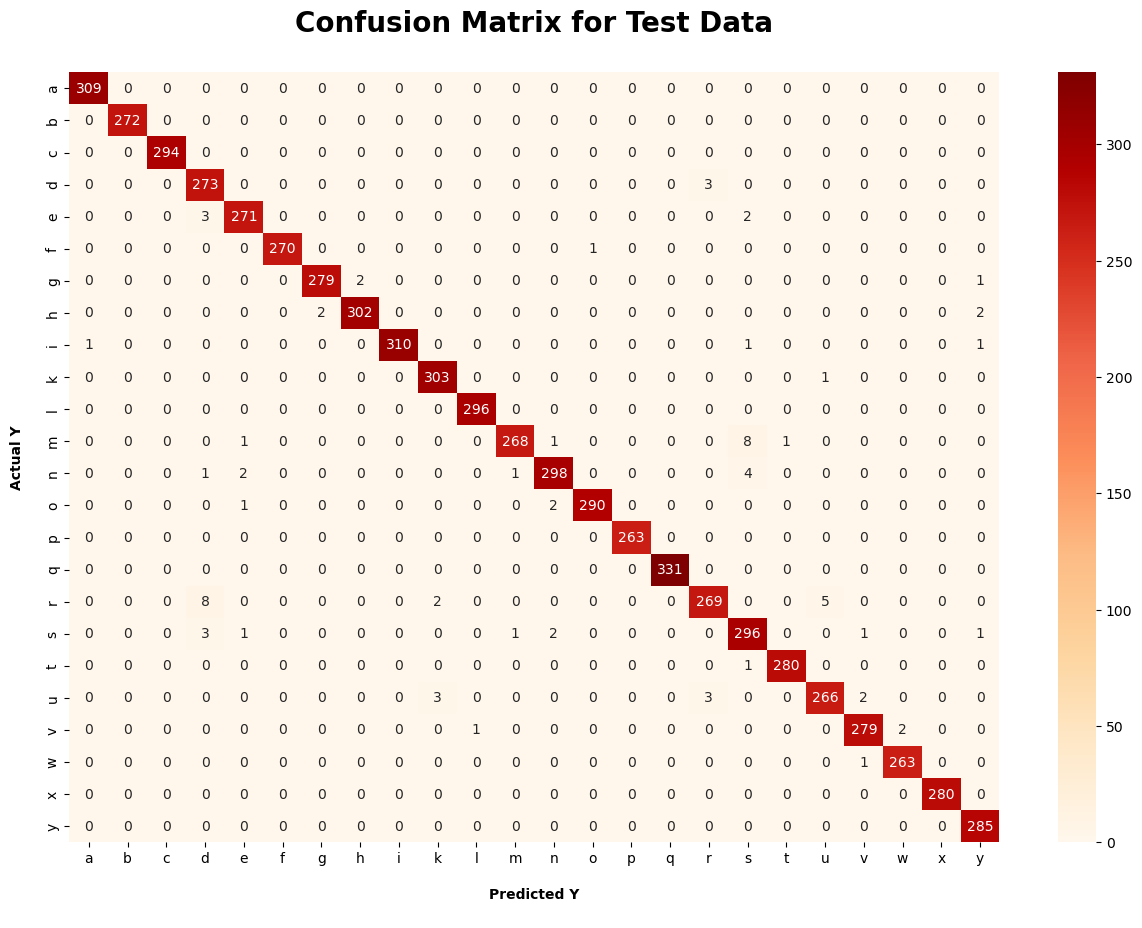

In [20]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Assessing model coefficients

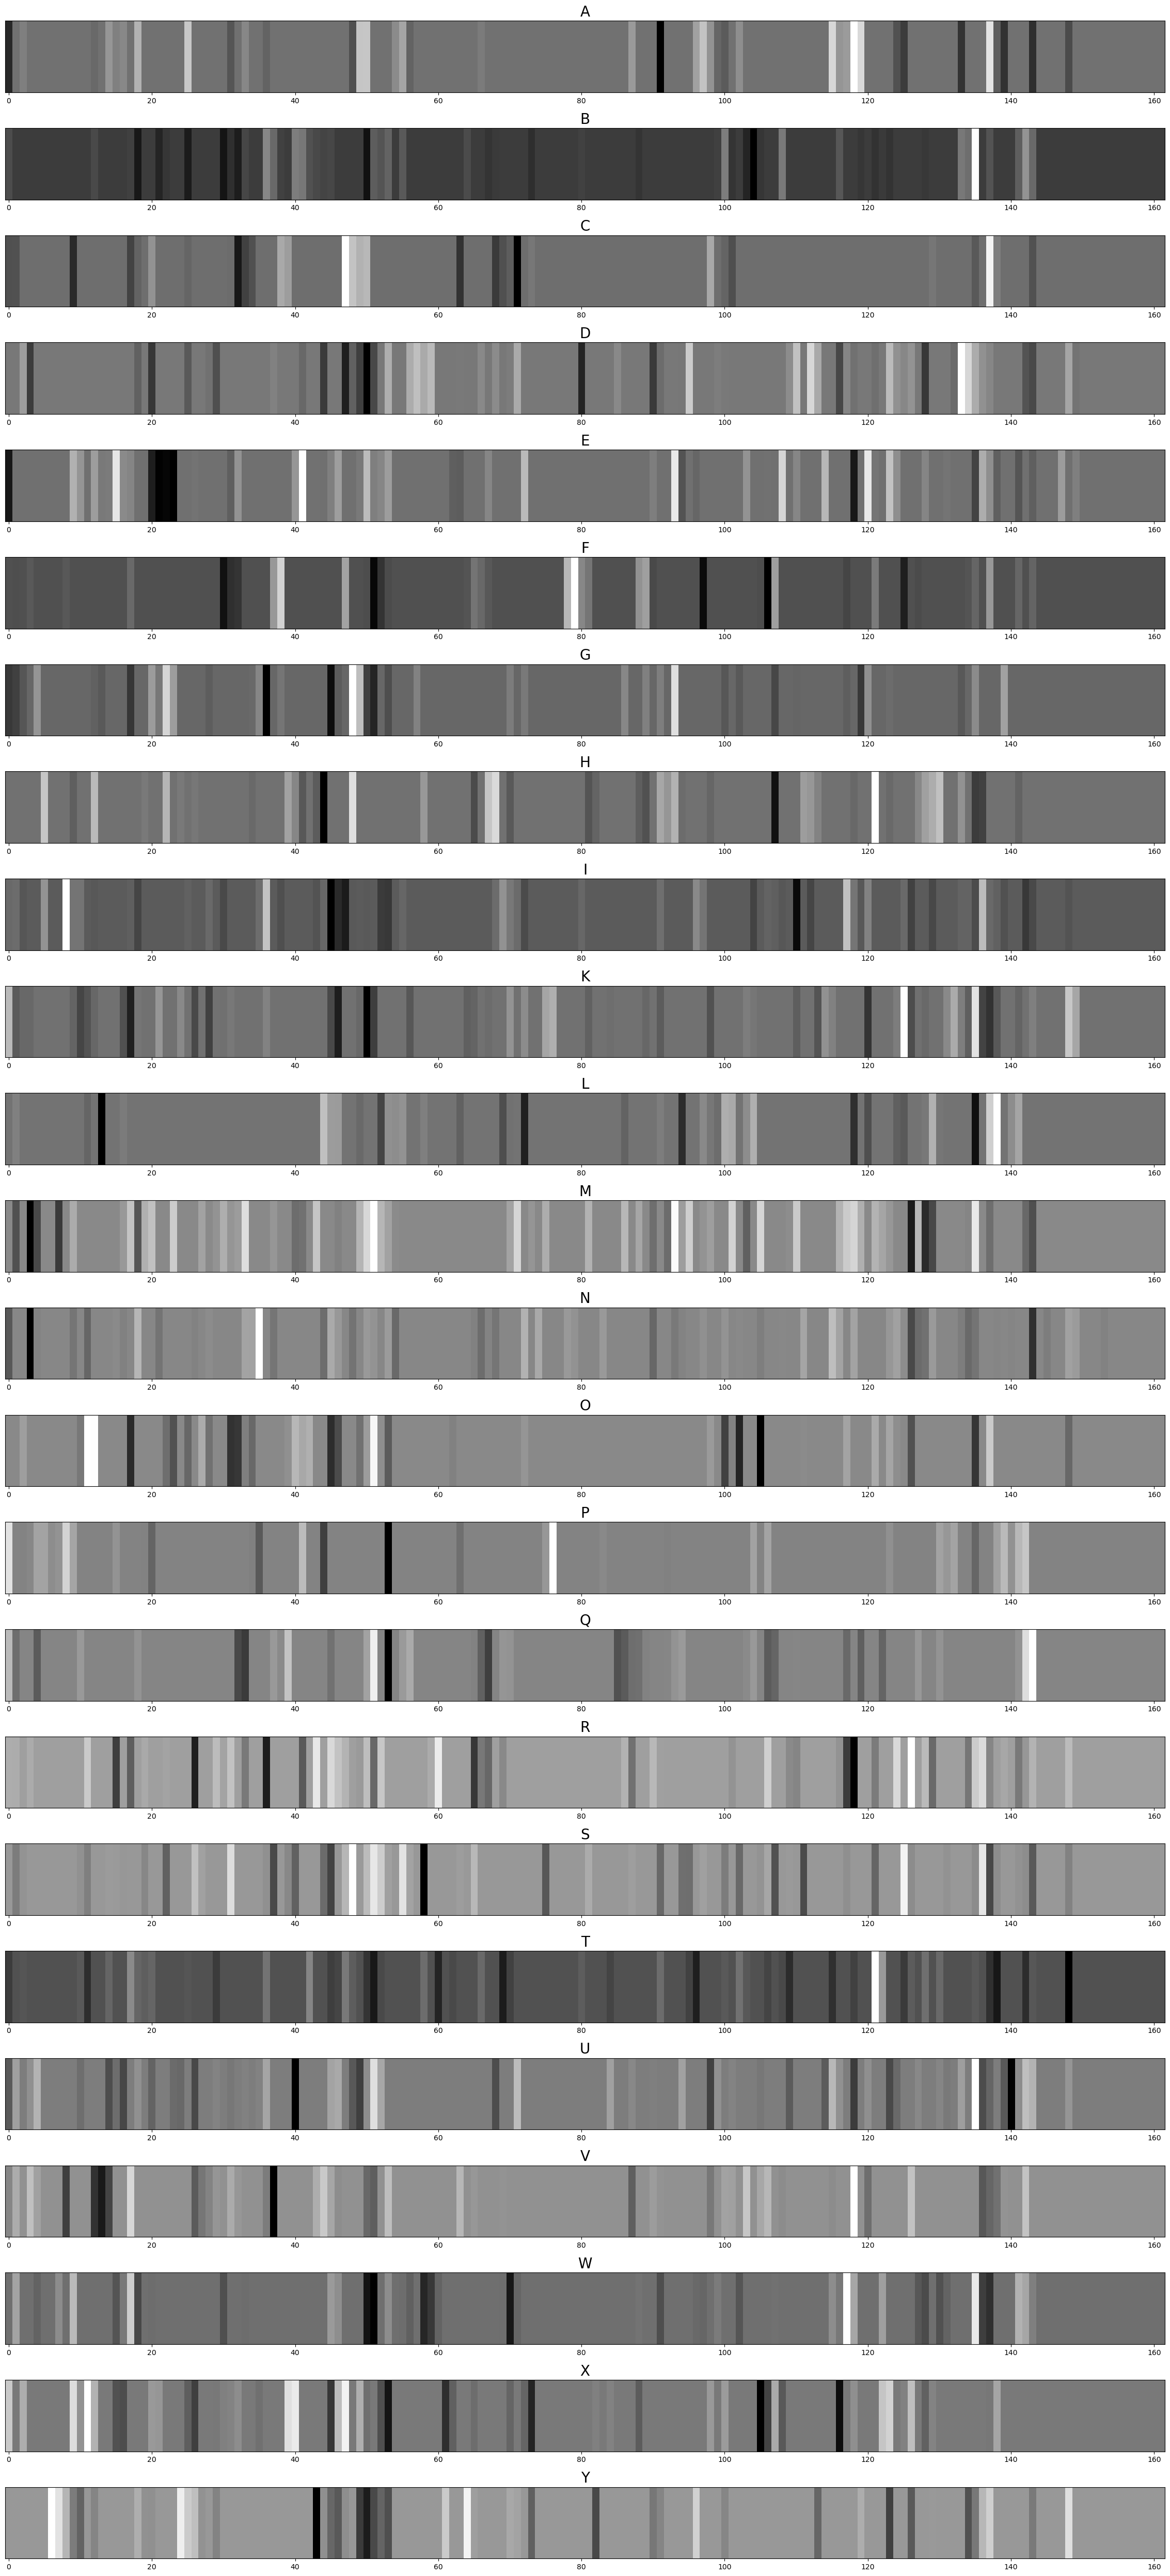

In [21]:
# Plotting of vector coefficients
letter_coef = my_log_reg.coef_

fig, axes = plt.subplots(24,1, figsize=(50, 50))

for i,coef in enumerate(letter_coef):
    axes[i].imshow(np.tile(coef, (10, 1)),cmap = 'gray')
    axes[i].set_title(alphabet[i].upper(),fontsize='20') #-> using alphabet_jz as the i is 0 to 24
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

**Comment:**
Lighter areas in the coefficient plots above indicate features which are important in the models interpretation for a given letter. Such areas are siginificant contributers to the model's classification 'decision'. Features in this notebook correspond to things like texture, edges and corners, if these features are present in the test image the model will look for this when classifying. 

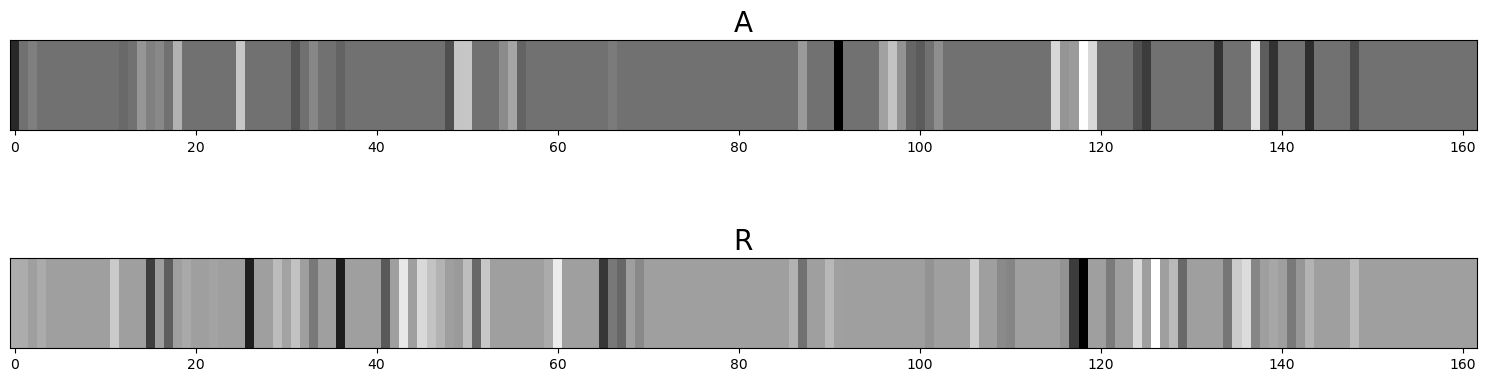

In [22]:
# Using confusion matrix identify two letters where misclassification occurs
# Assess vectors side by side to see if the coefficient vectors are similar
assess_coef(my_log_reg.coef_, 'a', 'r')


**Comment:**
Difficult to see if there is a cross over between two letters, the idea of this plot was to see which letters are most misclassified and feed them into this function to assess the degree of similarity between the two feature vectors.

### Test Image using unseen data

In [ ]:
# Load model
my_log_reg = joblib.load('../../model/my_files/my_log_reg_with_fe.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
# loading a test image for ASL sign 'C'
image_path = '../../model/my_files/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

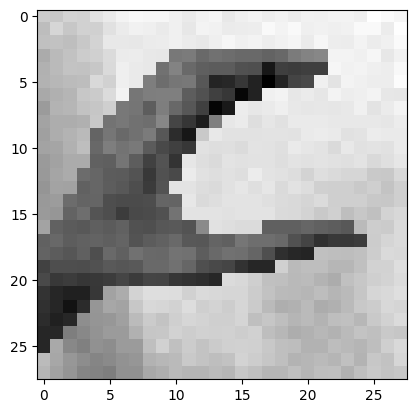

In [ ]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [ ]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [ ]:
# Reshaping to have dimesntions (28,28) -> to match X_train/X_test dimensions
test_img = image_array.reshape(28,28)

In [ ]:
feature_vec = extract_features(test_img)

In [ ]:
feature_vec.shape

(162,)

In [ ]:
feature_vec =feature_vec.reshape(1,-1)

In [ ]:
feature_vec.shape

(1, 162)

In [ ]:
pred = my_model.predict(feature_vec)

In [ ]:
pred

array([2])

In [ ]:
alphabet[pred[0]]

'c'

## Appendix

#### Attempt at getting hog_features, lbp_features and colour_feature vectors out of concatentated feature vectors

In [9]:
my_image = X.reshape(-1,28,28)
my_class = y

In [10]:
feature_vector, hog_image  = hog(my_image[my_class==1][0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
feature_vector.shape

(144,)

In [11]:
lbp_features = local_binary_pattern(my_image[my_class==1][0], P=8, R=1, method='uniform')
lbp_hist, bin_edges = np.histogram(lbp_features, bins=np.arange(0, lbp_features.max() + 2), density=True)
lbp_hist.shape

(10,)

In [12]:
col_hist, bin_edges = np.histogram(my_image[my_class==1][0].reshape(784,-1), bins=8 ,range=(0, 255))
col_hist.shape

(8,)

In [13]:
test_fv = extract_features(my_image[0])
test_fv[0:144].shape

(144,)

In [14]:
test_fv = extract_features(my_image[0])

hog_feature = test_fv[0:144]
lbp_feature = test_fv[144:154]
col_feature = test_fv[154:]

In [15]:
hog_feature.shape
hog_feature = hog_feature.reshape(12,12)

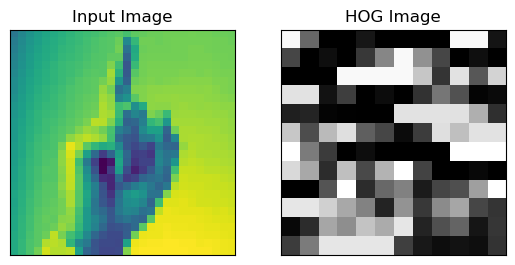

In [23]:
fig, axes = plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(my_image[0])
plt.title('Input Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(hog_feature, cmap='gray')
plt.title('HOG Feature')
plt.xticks([])
plt.yticks([])
plt.show()

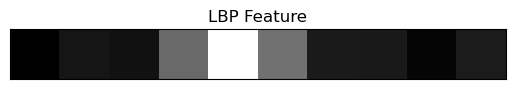

In [27]:
plt.imshow(lbp_feature.reshape(1,-1), cmap = 'gray')
plt.title('LBP Feature')
plt.xticks([])
plt.yticks([])
plt.show()

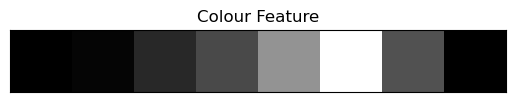

In [26]:
plt.imshow(col_feature.reshape(1,-1), cmap = 'gray')
plt.title('Colour Feature')
plt.xticks([])
plt.yticks([])
plt.show()

In [92]:
# TODO

# To split the resulting feature vector to get hog_feature, lbp_feature and colour_feature to better undestand the resulting feature vector and which features are extracted
# Create function where input would be a letter and outputs the above features along side the input image for interpretability
# Clean up code and add deeper insights into findings
# Add in  hyperparam training into log rog -> perhaps basic model and use same hyperparam setting for fair comparison